In [ ]:
from tensorflow import keras
import tensorflow as tf
import os
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,GlobalAveragePooling2D, Lambda, Conv2DTranspose, concatenate
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import Model
from keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
from keras.preprocessing import image
import seaborn as sns
import zipfile
import shutil
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

Image_Width=256  
Image_Height=256
Image_Size=(Image_Width,Image_Height)
Image_Channels=1

In [ ]:
train_dir = "/content/drive/MyDrive/IPDA_segmentation/Train"
train_images_dir = os.path.join(train_dir, 'IDS')
train_labels_dir = os.path.join(train_dir, 'GROUNDTRUTH')

In [ ]:
validation_dir = "/content/drive/MyDrive/IPDA_segmentation/Test"
validation_images_dir = os.path.join(validation_dir, 'IDS')
validation_labels_dir = os.path.join(validation_dir, 'GROUNDTRUTH')

In [ ]:
from keras.engine.input_layer import Input

input= Input((Image_Width, Image_Height, Image_Channels))

c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (input)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.3) (c3)
c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)


u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c3)
u6 = concatenate([u6, c2])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c1])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)



output = Conv2D(1, (1, 1), activation='sigmoid') (c7)



In [ ]:
model_segment= Model(inputs= input, outputs= output) 

In [ ]:
model_segment.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
from keras.optimizers import SGD
model_segment.compile(loss='binary_crossentropy', optimizer=SGD(momentum= 0.9 ),metrics=['accuracy'])

In [ ]:
!rmdir /content/MASK_TRAIN_DIR1/.ipynb_checkpoints

In [ ]:
!rmdir /content/MASK_VALIDATION_DIR1/.ipynb_checkpoints

In [ ]:
SEED= 10
np.random.seed(SEED)
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_image_generator = train_datagen.flow_from_directory(train_images_dir,
                                                              target_size=Image_Size,
                                                              class_mode=None,
                                                              batch_size= 8,
                                                              color_mode='grayscale',
                                                              seed=SEED)

train_mask_generator = train_datagen.flow_from_directory(train_labels_dir,
                                                             target_size=Image_Size,
                                                             class_mode=None,  
                                                             batch_size= 8,
                                                             color_mode='grayscale',
                                                             seed=SEED)

val_datagen = ImageDataGenerator(rescale=1. / 255)
val_image_generator = val_datagen.flow_from_directory(validation_images_dir,
                                                          target_size=Image_Size,
                                                          class_mode=None,
                                                          batch_size= 8,
                                                          color_mode='grayscale',
                                                          seed=SEED)

val_mask_generator = val_datagen.flow_from_directory(validation_labels_dir,
                                                         target_size=Image_Size,
                                                         class_mode=None,
                                                         batch_size=8,
                                                         color_mode='grayscale',
                                                         seed=SEED)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)




Found 400 images belonging to 1 classes.
Found 400 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [ ]:
os.chdir('/content/MASK_TRAIN_DIR1')

In [ ]:
from keras.callbacks import TensorBoard   
earlystopping= tf.keras.callbacks.EarlyStopping(patience = 10)                            
tb = TensorBoard(log_dir='./logs/', batch_size=8, write_graph=True)

segmentation_history= model_segment.fit(train_generator,epochs= 100,verbose= 1,validation_data= val_generator, steps_per_epoch= 50, validation_steps= 12, callbacks= [earlystopping, tb])      

Epoch 1/100
50/50 [==============================] - 596s 12s/step - loss: 0.4500 - accuracy: 0.8880 - val_loss: 0.4034 - val_accuracy: 0.8909
Epoch 2/100
50/50 [==============================] - 45s 902ms/step - loss: 0.3448 - accuracy: 0.8952 - val_loss: 0.2372 - val_accuracy: 0.8907
Epoch 3/100
50/50 [==============================] - 45s 914ms/step - loss: 0.2467 - accuracy: 0.9045 - val_loss: 0.2530 - val_accuracy: 0.9023
Epoch 4/100
50/50 [==============================] - 47s 947ms/step - loss: 0.2086 - accuracy: 0.9150 - val_loss: 0.4103 - val_accuracy: 0.8953
Epoch 5/100
50/50 [==============================] - 44s 884ms/step - loss: 0.1863 - accuracy: 0.9237 - val_loss: 0.2570 - val_accuracy: 0.9135
Epoch 6/100
50/50 [==============================] - 45s 911ms/step - loss: 0.1314 - accuracy: 0.9487 - val_loss: 0.1704 - val_accuracy: 0.9348
Epoch 7/100
50/50 [==============================] - 46s 932ms/step - loss: 0.1047 - accuracy: 0.9600 - val_loss: 0.1106 - val_accuracy: 

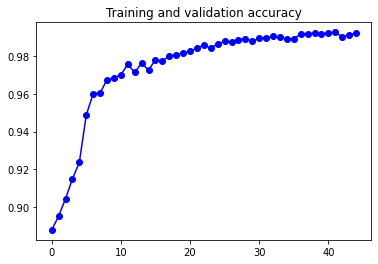

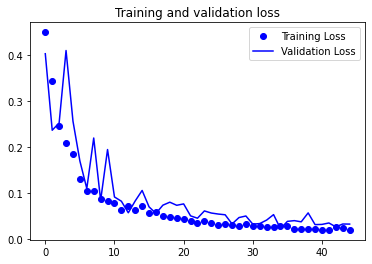

In [ ]:
import matplotlib.pyplot as plt
acc_segment = segmentation_history.history['accuracy']
val_acc_segment = segmentation_history.history['accuracy']
loss_segment = segmentation_history.history['loss']
val_loss_segment = segmentation_history.history['val_loss']

epochs_segment = range(len(acc_segment))

plt.plot(epochs_segment, acc_segment, 'bo', label='Training accuracy')
plt.plot(epochs_segment, val_acc_segment, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs_segment, loss_segment, 'bo', label='Training Loss')
plt.plot(epochs_segment, val_loss_segment, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_segment.save('segmentation.h5')

In [ ]:
import cv2
import numpy as np

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect


def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped


def findLargestCountours(cntList, cntWidths):
    newCntList = []
    newCntWidths = []

    first_largest_cnt_pos = cntWidths.index(max(cntWidths))

    newCntList.append(cntList[first_largest_cnt_pos])
    newCntWidths.append(cntWidths[first_largest_cnt_pos])

    cntList.pop(first_largest_cnt_pos)
    cntWidths.pop(first_largest_cnt_pos)

    seccond_largest_cnt_pos = cntWidths.index(max(cntWidths))

    newCntList.append(cntList[seccond_largest_cnt_pos])
    newCntWidths.append(cntWidths[seccond_largest_cnt_pos])

    cntList.pop(seccond_largest_cnt_pos)
    cntWidths.pop(seccond_largest_cnt_pos)
    return newCntList, newCntWidths


def convert_object(mask, image):
    gray = mask
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    gray = cv2.medianBlur(gray, 5)
    edged = cv2.Canny(gray, 30, 400)
    countours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    cnts = sorted(countours, key=cv2.contourArea, reverse=True)
    screenCntList = []
    scrWidths = []
    for cnt in cnts:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        screenCnt = approx

        if (len(screenCnt) == 4):
            (X, Y, W, H) = cv2.boundingRect(cnt)
            screenCntList.append(screenCnt)
            scrWidths.append(W)

    if len(scrWidths) != 2:
        print('ID Card not found.')
        return None
    else:
        screenCntList, scrWidths = findLargestCountours(screenCntList, scrWidths)

        if not len(screenCntList) >= 2:  # there is no rectangle found
            return None
        elif scrWidths[0] != scrWidths[1]:  # mismatch in rect
            return None

        pts = screenCntList[0].reshape(4, 2)
        warped = four_point_transform(image, pts)
        return warped

In [ ]:

def load_data(INPUT_FILE):
    
         img = cv2.imread(INPUT_FILE, cv2.IMREAD_GRAYSCALE)
         img = img/255.0
         height, width = img.shape[:2]
         img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
         img = img.reshape(1, 256, 256, 1)                                             
         return img, height, width

In [ ]:
def predict_image(model, image):
    predict = model.predict(image, verbose=1)
    return predict[0] 

In [ ]:
Source= os.listdir("/content/drive/MyDrive/IPDA_segmentation/Test/IDS/Ids")
os.chdir("/content/drive/MyDrive/IPDA_segmentation/Test/IDS/Ids")
img_list= []
output_image= []
for n in range(0,4):
   img, h, w = load_data(Source[n])
   img_list.append(img)

   output_image.append(predict_image(model_segment, img_list[n]) )
   

   

1/1 [==============================] - 0s 19ms/step


In [ ]:
from matplotlib import gridspec
gs = gridspec.GridSpec(1, len(img_list))

In [ ]:
type(output_image[n])

numpy.ndarray

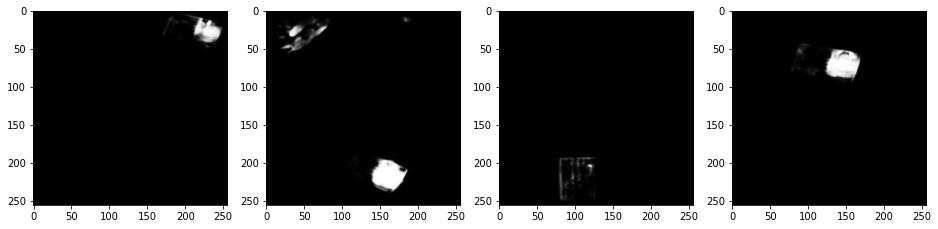

In [ ]:
fig = plt.figure(figsize=(16, 6))
for n in range(len(output_image)):
    ax = fig.add_subplot(gs[n])
    data = output_image[n]
    ax.imshow(data, cmap="gray") 

In [ ]:
print('Cut it out...')
mask_image = cv2.resize(output_image[n], (w, h))
warped = convert_object(mask_image, cv2.imread('/content/drive/MyDrive/IPDA_segmentation/Test/IDS/Ids/fake_id_200__front.png'))
print('Save output files...', '/content/drive/MyDrive/IPDA_segmentation/Test/Output')
plt.imsave('/content/drive/MyDrive/IPDA_segmentation/Test/Mask_output', mask_image, cmap='gray')      
